Import the frogger environment from the course website

In [3]:
!wget https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip
!unzip -q frogger.zip

--2021-03-03 02:53:55--  https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip
Resolving sites.google.com (sites.google.com)... 108.177.98.102, 108.177.98.100, 108.177.98.113, ...
Connecting to sites.google.com (sites.google.com)|108.177.98.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attredirects=0 [following]
--2021-03-03 02:53:55--  https://sites.google.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attredirects=0
Reusing existing connection to sites.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://1b8e3dd4-a-1e6e9713-s-sites.googlegroups.com/a/g.clemson.edu/cpsc-drl/assignments/hw2/frogger.zip?attachauth=ANoY7cquVT_hmnlWfrpJok53r_nM1pNC9tfSRdTyaWOk7IsYoubF1sPtQ88TcNsxLjG3hbBzowbrZv3kWeE7VUuReyxbnzFUf3Uw-rlYOyms-FY0sOSMAr90Euc6aBzCw-vm_t-i0dpgq2swon3YsgUqFmS7j12tkHyzcS-o-oGV5jt

In [4]:
!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame

"""ENVIRONMENT"""
import gym
import frogger_env
#import pygame
gym.logger.set_level(40)                                                        #suppresses warning messages, displays only error messages

"""MODELS AND TOOLS FOR OPTIMIZATION AND OTHER COMPUTATIONS"""
import time
import numpy as np
import torch
import torch.nn as nn                                                           #contains various NN layers
import torch.nn.functional as F                                                 #includes various functions such as convolution etc.
import torch.optim as optim                                                     #contains various optimization algorithms
import random
from random import sample
from collections import deque

"""VISUALIZATION"""
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

"""I/O"""
from pathlib import Path
import os 

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

Display for visualization


In [5]:
display = Display(visible=0, size=(600, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Let's test things out!

In [6]:
env=gym.make('frogger-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
env.reset()
done=False
while not done:
  action=1#env.action_space.sample()
  observation,reward,done,info=env.step(action)
env.close()
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>


The observation that the agent receives is a history of lidar scans + distance to the goal.

The action space consists of three actions 0: stand still, 1: move up, 2: move down

In [7]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(0.0, 1.0, (61,), float32)
action space: Discrete(3)


Some useful functions

In [8]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your Q network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)

###Q1. DQN
Implement below DQN to solve the frogger environment and enable the agent to reach the other side of the highway.

Please, refer to the project descriprtion for more details.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


KeyboardInterrupt: ignored

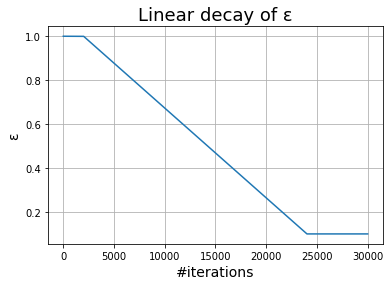

In [30]:
from random import choices
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE NEURAL NETWORK"""
class network(nn.Module): 
  def __init__(self,observations,actions,hu1=60,hu2=60,hu3=30):                 #define the network architecture - #hidden layers, #hidden units, and the layer types
    super(network,self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is a fully-connected layer with #I/P=observations and #hidden units=hu1
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is a fully-connected layer with #I/P=hu1 and #hidden units=hu2
    self.l3=nn.Linear(hu2,hu3)                                                  #layer3 is a fully-connected layer with #I/P=hu2 and #hidden units=hu3
    self.l4=nn.Linear(hu3,actions)                                              #layer4 is a fully-connected layer with #I/P=hu3 and #hidden units=actions (it's 3 for the first problem)
    #initialize interconnection weights and bias weights using a probability
    #distribution (code below is for a normal distribution with μ=0 and σ=1)
    #nn.init.normal_(self.l1.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l1.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l2.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l2.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l3.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l3.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l4.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l4.bias.data,mean=0,std=1)

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          #check if the I/P is a tensor or not
      x=torch.tensor(x,device=device,dtype=torch.float32)                       #convert the I/P to a tensor and move it to 'device'
      x=x.unsqueeze(0)
    x=F.relu(self.l1(x))                                                        #activation functions of layers 1 and 2 are both ReLU, layer 3 uses no activation function since it's the O/P layer
    x=F.relu(self.l2(x))
    x=F.relu(self.l3(x))
    x=self.l4(x)
    return x



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE DQN AGENT"""
class DQNagent():
  def __init__(self,observations,actions,batchSize,epochs,alpha):
    self.batchSize=batchSize
    self.epochs=epochs
    self.alpha=alpha
    self.qnet=network(observations,actions).to(device)                          #define a Q-network object of type 'network', initialize its weights θ randomly and move it to the GPU
    self.tnet=network(observations,actions).to(device)                          #define a target-network object of type 'network' and move it to the GPU
    self.tnet.load_state_dict(self.qnet.state_dict())                           #equate the weights θminus of the target network to θ
    self.optimizer=optim.RMSprop(self.qnet.parameters(),lr=self.alpha)          #define an optimizer to perform gradient descent

  def train(self,env,seed,gamma,maxSteps,meanReward100,epsilon,C,qLength,taw):
    self.seed=seed
    self.gamma=gamma
    self.epsilon=epsilon
    self.taw=taw
    self.C=C
    torch.manual_seed(self.seed) 
    np.random.seed(self.seed)
    random.seed(self.seed)
    env.seed(self.seed)

    self.episode_reward=[]                                                      #stores the reward of each episode
    self.evaluationScoresEpisode=[]                                             #stores the evaluation score of roll-out after each episode
    self.evaluationScore=[]                                                     #stores the evaluation scores of roll-outs performed after every 500 time-steps
    self.results=[]                                                             #stores the consolidated results of training
    self.D=deque(maxlen=qLength)                                                #declare the experience replay buffer and define its maximum length
    self.numEpisodes=0                                                          #keeps track of the #episodes collected so far
    self.numExperiences=0                                                       #keeps track of the #experiences collected so far
    while self.numExperiences<maxSteps:
      s=env.reset()                                                             #reset the environment at the start of each episode
      terminal=False                                                            #set this flag when the current state is terminal
      self.episode_reward.append(0.0)
      while not terminal:
        sP,terminal=self.collect_experience(env,s,self.epsilon[self.numExperiences])
        s=sP                                                                    #after an experience is colleted, the next state becomes the current state
        self.numExperiences+=1                                                  #every time an experience is collected, this variable is incremented
        if self.numExperiences>=maxSteps:break                                  #the loop breaks when the #experiences collected so far exceeds 'maxSteps'
        if len(self.D)>=self.batchSize:                                         #batches are sampled from the experience replay buffer only after the #elements in the latter exceeds the batch size
          batch=choices(self.D,k=self.batchSize)                                #randomly sample a batch of experiences with replacement from the experience replay buffer
          batch=np.array(batch)
          batch=[np.vstack(exp) for exp in batch.T]
          sBatch,aBatch,rBatch,sPBatch,isFailureBatch=batch
          sBatch=torch.from_numpy(sBatch).float().to(device)                    #convert experience variables to tensors and move them to the GPU
          aBatch=torch.from_numpy(aBatch).float().to(device)
          rBatch=torch.from_numpy(rBatch).float().to(device)
          sPBatch=torch.from_numpy(sPBatch).float().to(device)
          isFailureBatch=torch.from_numpy(isFailureBatch).float().to(device)
          for epoch in range(self.epochs):                                      #train the Q-network using the selected batch of experiences
            self.learn(sBatch,aBatch,sPBatch,rBatch,isFailureBatch)
        if self.numExperiences%self.C==0:                                       #use Polyask averaging to update the weights of the target-network after every C time-steps (or experiences)
          #hard update of the weights of the target network - equate the weights of the target network to that of the Q-network
          self.tnet.load_state_dict(self.qnet.state_dict())
          #soft update (Polyask averaging) of the weights of the target network - θ'=τθ+(1-τ)θ'
          #self.tnet.state_dict()['l1.weight']=(self.taw*self.qnet.state_dict()['l1.weight'])+((1-self.taw)*self.tnet.state_dict()['l1.weight'])
          #self.tnet.state_dict()['l1.bias']=(self.taw*self.qnet.state_dict()['l1.bias'])+((1-self.taw)*self.tnet.state_dict()['l1.bias'])
          #self.tnet.state_dict()['l2.weight']=(self.taw*self.qnet.state_dict()['l2.weight'])+((1-self.taw)*self.tnet.state_dict()['l2.weight'])
          #self.tnet.state_dict()['l2.bias']=(self.taw*self.qnet.state_dict()['l2.bias'])+((1-self.taw)*self.tnet.state_dict()['l2.bias'])
          #self.tnet.state_dict()['l3.weight']=(self.taw*self.qnet.state_dict()['l3.weight'])+((1-self.taw)*self.tnet.state_dict()['l3.weight'])
          #self.tnet.state_dict()['l3.bias']=(self.taw*self.qnet.state_dict()['l3.bias'])+((1-self.taw)*self.tnet.state_dict()['l3.bias'])
          #self.tnet.state_dict()['l4.weight']=(self.taw*self.qnet.state_dict()['l4.weight'])+((1-self.taw)*self.tnet.state_dict()['l4.weight'])
          #self.tnet.state_dict()['l4.bias']=(self.taw*self.qnet.state_dict()['l4.bias'])+((1-self.taw)*self.tnet.state_dict()['l4.bias'])
        if self.numExperiences%500==0:                                          #perform a roll-out after every 500 time-steps
          temp1,temp2=self.evaluate(env)
          self.evaluationScore.append(temp1)
      self.numEpisodes+=1                                                       #every time an episode terminates, this variable is incremented
      evalScore,evalScoreSTD=self.evaluate(env)                                 #perform a roll-out at the end of each episode to obtain the evaluation scores
      self.evaluationScoresEpisode.append(evalScore)                            #add the evaluation score of the latest roll-out to the list 'self.evaluationScoresEpisode'
      mean100EpisodeReward=np.mean(self.episode_reward[-100:])                  #mean reward of the last 100 episodes
      std100EpisodeReward=np.std(self.episode_reward[-100:])                    #std of the rewards of the last 100 episodes
      mean100ROEvalScore=np.mean(self.evaluationScoresEpisode[-100:])           #mean evaluation score of the last 100 roll-outs
      std100ROEvalScore=np.std(self.evaluationScoresEpisode[-100:])             #std of the evaluation scores of the last 100 roll-outs
      self.results.append((self.numExperiences,mean100EpisodeReward,
                           mean100ROEvalScore,np.mean(self.evaluationScore)))   #add the results of the current roll-out to the list 'self.results'
      print('Episode#: {:d}, Experience#: {:d}, Mean training reward (last 100 episodes): {:.2f}, Mean evaluation reward (last 100 RO): {:.2f}, STD of evaluation reward (last 100 RO): {:.2f}'.format(self.numEpisodes-1,self.numExperiences,\
                  mean100EpisodeReward,mean100ROEvalScore,std100ROEvalScore))
      if mean100ROEvalScore>0.8:break                                          #variant of early stop - stop further training if 'mean100EvalScore'>0.72
    print('Mean evaluation reward for all ROs: {:.2f}, STD of evaluation reward for all ROs: {:.2f}'.format(np.mean(self.evaluationScore),np.std(self.evaluationScore)))
    return self.results,self.qnet                                               #return the results of training and the model

  def collect_experience(self,env,s,epsilon):                                   #call this function to collect an experience
    a=self.epsilonGreedy(s,epsilon)
    sP,r,terminal,info=env.step(a)
    isTruncated='TimeLimit.truncated' in info and info['TimeLimit.truncated']
    isFailure=terminal and not isTruncated
    self.D.append((s,a,r,sP,float(isFailure)))
    self.episode_reward[-1]+=r
    return sP,terminal

  def epsilonGreedy(self,s,epsilon):                                            #this function uses the epsilon-greedy approach to select the next action
    s=torch.tensor(s).type(torch.FloatTensor).to(device)
    with torch.no_grad():
      Q=self.qnet(s).cpu().detach().data.numpy().squeeze()
    a=np.random.choice([[i for i in range(len(Q))],np.argmax(Q)],size=1,
                       p=[epsilon,1-epsilon])
    a=np.stack(a).astype(None)
    if a.ndim==1:
       a=int(a)
    else:
      a=int(np.random.choice(a.flatten(),size=1,
                             p=[1/len(Q) for i in range(len(Q))]))
    return a

  def learn(self,sBatch,aBatch,sPBatch,rBatch,isFailureBatch):                  #this function trains the Q-network using backpropagation and weight update  
    QP=self.tnet(sPBatch).detach()                                              #the value of Q'(s',a') is evaluated using the target-network
    maxQP=QP.max(1)[0].unsqueeze(1)
    target=rBatch+(self.gamma*maxQP*(1-isFailureBatch))                         #the target
    target=target.type(torch.FloatTensor).to(device)                            #change the type of the target to 'float32' and then move it to 'device'
    aBatch=aBatch.type(torch.LongTensor).to(device)                             #change the type of the action to 'float32' and then move it to 'device'
    prediction=self.qnet(sBatch).gather(1,aBatch)                               #the prediction Q(s,a) is evaluated using the Q-network
    loss=F.mse_loss(prediction,target)                                          #the mean squared error loss between the prediction and the target
    self.optimizer.zero_grad()                                                  #set all gradients to zero before backpropagation for a given epoch begins
    loss.backward()                                                             #the mean-squared errors are backpropagated
    self.optimizer.step()                                                       #optimize the weights using the backpropagated error

  def evaluate(self,env,rollOuts=1):                                            #this function performs a fixed #roll-outs at the end of each training episode and evaluates the associated rewards
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s1=env.reset()
      terminal1=False
      while not terminal1:
        s1=torch.tensor(s1).float().to(device)
        a1=self.greedy(s1).numpy()
        s1,r1,terminal1,info1=env.step(a1)
        rewards[-1]+=r1
    return np.mean(rewards),np.std(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to the Q-values of the state 's'
    with torch.no_grad():
      Q=self.qnet(s)
    Q=Q.cpu()
    return np.argmax(Q)



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('frogger-v0')                                                      #declare the environment variable
batchSize=32                                                                    #mini-batch size
epochs=1                                                                        ##training epochs per mini-batch
alpha=1e-4                                                                      #the learning rate
gamma=.93                                                                       #the discount factor
maxSteps=30000                                                                  #maximum time-steps (or experiences) for which the agent acts in the world
taw=0.01                                                                        #for Polyak (or soft) update of the target network weights
C=100                                                                           #defines after how many experiences (or time-steps) the target-network weights are updated
seed=6                                                                         #random seed used for random initialization of the network weights, the environment and various random function
qLength=50000                                                                   #size of the experience replay buffer
meanReward100=env.spec.reward_threshold                                         #mean reward earned over the last 100 episodes
observations=env.observation_space.shape[0]                                     ##observations or I/P features
actions=env.action_space.n                                                      #actions



"""LINEAR DECAY OF EPSILON"""
#ε=1 for the first 'randomExplore' #time-steps, then it decays to 0.1 within 80%
#of the total #time-steps. For the remaining time-steps, ε=0.1
randomExplore=2000                                                              ##times-teps for which the agent randomly explores the environment
m,b=np.polyfit(np.array([randomExplore,np.ceil((0.8*maxSteps)-1)]),
               np.array([1,0.1]),deg=1)                                         #parameters for the linear decay of ε
epsilon=[(m*i)+b for i in np.linspace(randomExplore,
                                      int(np.ceil(0.8*maxSteps-1)),
                                      int(np.ceil(0.8*maxSteps))-randomExplore)]#decaying part of ε
epsilon=np.concatenate((np.ones((randomExplore)),epsilon,
                        0.1*np.ones((maxSteps-randomExplore-len(epsilon)))))    #concatenate all ε parts
for i in range(len(epsilon)):                                                   #if the value of ε at a point of discontinuity exceeds 1, set that value to 1
  if epsilon[i]>1:epsilon[i]=np.floor(epsilon[i])
plt.figure(1)                                                                   #plot values of epsilon
plt.grid('on')
plt.ylabel('\u03B5',fontsize=14)
plt.xlabel('#iterations',fontsize=14)
plt.title('Linear decay of \u03B5',fontsize=18)
plt.plot(np.linspace(0,len(epsilon)-1,len(epsilon)),epsilon)



"""DQN"""
env.seed(seed)                                                                  #set the seed for the environment
agent=DQNagent(observations,actions,batchSize,epochs,alpha)                     #create an object of type 'DQNagent'
trainResults,model=agent.train(env,seed,gamma,maxSteps,meanReward100,epsilon,C,
                               qLength,taw)                                     #train the DQN agent
save_checkpoint(model,'model1',1)                                               #save the trained model



"""PLOT THE RESULTS"""
trainResults=np.array(trainResults)
numExperiences=trainResults[:,0]                                                #total #time-steps (or experiences)
mean100EpisodeReward=trainResults[:,1]                                          #mean reward for the last 100 episodes
mean100ROEvalScore=trainResults[:,2]                                            #mean evaluation score for the last 100 episodic roll-outs
evaluationScore=trainResults[:,3]                                               #evaluation scores of roll-outs performed after every 500 time-steps

figure1=plt.figure()                                                            #plot the #time-steps
axis1=figure1.add_subplot(111)
plt.plot(numExperiences,linewidth=2)
plt.ylabel('#time-steps')
plt.xlabel('#episodes')
axis1.set_title('Total #time-steps')

figure2=plt.figure()                                                            #plot the mean reward for the last 100 episodes
axis2=figure2.add_subplot(111)
plt.plot(mean100EpisodeReward,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#episodes')
axis2.set_title('Average training reward for the last 100 episodes')

figure3=plt.figure()                                                            #plot the mean evaluation score for the last 100 roll-outs
axis3=figure3.add_subplot(111)
plt.plot(mean100ROEvalScore,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#episodes')
axis3.set_title('Average evaluation score for the last 100 episodic roll-outs')

figure4=plt.figure()                                                            #plot the mean evaluation score over all roll-outs
axis4=figure4.add_subplot(111)
plt.plot(evaluationScore,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#roll-outs')
axis4.set_title('Average evaluation score over all roll-outs')

Test the policy

In [21]:
"""TESTING"""
env=gym.make('frogger-v0')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
#env.seed(10)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent.greedy(s).numpy()
  s,r,terminal,info=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>

Episode reward:1.11


###Q2a. DQN Extension - Double DQN
Implement below Double DQN to solve the frogger environment and enable the agent to reach the other side of the highway.

Please, refer to the project descriprtion for more details.

In [ ]:
from random import choices
"""SWITCH TO A GPU IF ONE IS AVAILABLE"""
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



"""DEFINITION OF THE ARCHITECTURE AND THE ATTRIBUTES OF THE NEURAL NETWORK"""
class network2(nn.Module):
  def __init__(self,observations,actions,hu1=120,hu2=120,hu3=90):               #define the network architecture - #hidden layers, #hidden units, and the layer types
    super(network2,self).__init__()
    self.l1=nn.Linear(observations,hu1)                                         #layer1 is a fully-connected layer with #I/P=observations and #hidden units=hu1
    self.l2=nn.Linear(hu1,hu2)                                                  #layer2 is a fully-connected layer with #I/P=hu1 and #hidden units=hu2
    self.l3=nn.Linear(hu2,hu3)                                                  #layer3 is a fully-connected layer with #I/P=hu2 and #hidden units=hu3 (it's 3 in first problem)
    self.l4=nn.Linear(hu3,actions)                                              #layer4 is a fully-connected layer with #I/P=hu3 and #hidden units=actions (it's 3 in first problem)
    #initialize interconnection weights and bias weights using a probability
    #distribution (code below is for a normal distribution with μ=0 and σ=1)
    #nn.init.normal_(self.l1.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l1.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l2.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l2.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l3.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l3.bias.data,mean=0,std=1)
    #nn.init.normal_(self.l4.weight.data,mean=0,std=1)
    #nn.init.normal_(self.l4.bias.data,mean=0,std=1)

  def forward(self,x):                                                          #forward propagation function
    if not isinstance(x,torch.Tensor):                                          #check if the I/P is a tensor or not
      x=torch.tensor(x,device=device,dtype=torch.float32)                       #convert the I/P to a tensor and move it to 'device'
      x=x.unsqueeze(0)
    x=F.relu(self.l1(x))                                                        #activation functions of layers 1 and 2 are both ReLU, layer 3 uses no activation function since it's the O/P layer
    x=F.relu(self.l2(x))
    x=F.relu(self.l3(x))
    x=self.l4(x)
    return x



"""DEFINITION OF THE CHARACTERISTICS AND ATTRIBUTES OF THE DOUBLE DQN AGENT"""
class DoubleDQNagent():
  def __init__(self,observations,actions,batchSize,epochs,alpha):
    self.batchSize=batchSize
    self.epochs=epochs
    self.alpha=alpha
    self.qnet=network2(observations,actions).to(device)                         #define a Q-network object of type 'network2', initialize its weights θ randomly and move it to the GPU
    self.tnet=network2(observations,actions).to(device)                         #define a target-network object of type 'network2', and move it to the GPU
    self.tnet.load_state_dict(self.qnet.state_dict())                           #equate the weights θminus of the target-network to θ
    self.optimizer=optim.RMSprop(self.qnet.parameters(),lr=self.alpha)          #define an optimizer to perform gradient descent for the Q-network

  def train(self,env,seed,gamma,maxSteps,meanReward100,epsilon,C,qLength,taw):
    self.seed=seed
    self.gamma=gamma
    self.epsilon=epsilon
    self.taw=taw
    self.C=C
    torch.manual_seed(self.seed)
    np.random.seed(self.seed)
    random.seed(self.seed)
    env.seed(self.seed)

    self.episode_reward=[]                                                      #stores the reward of each episode
    self.evaluationScoresEpisode=[]                                             #stores the evaluation score of each episodic roll-out
    self.evaluationScore=[]                                                     #stores the evaluation scores of roll-outs performed after every 500 time-steps
    self.results=[]                                                             #stores the consolidated results of training
    self.D=deque(maxlen=qLength)                                                #declare the experience replay buffer and define its maximum length
    self.numEpisodes=0                                                          #keeps track of the #episodes collected so far
    self.numExperiences=0                                                       #keeps track of the #experiences collected so far
    while self.numExperiences<maxSteps:
      s=env.reset()                                                             #reset the environment at the start of each episode
      terminal=False                                                            #set this flag when the current state is terminal
      self.episode_reward.append(0.0)                                           #the episode reward at the start of an episode is 0
      while not terminal:
        sP,terminal=self.collect_experience(env,s,self.epsilon[self.numExperiences])#call this function to collect an experience
        self.numExperiences+=1                                                  #every time an experience is collected, this variable is incremented
        s=sP                                                                    #after an experience is colleted, the next state becomes the current state
        if self.numExperiences>=maxSteps:break                                  #break the loop when the number of experiences collected so far exceeds its maximum limit
        if len(self.D)>=self.batchSize:                                         #batches are sampled from the experience replay buffer only after the #elements in the latter exceeds the batch size
          batch=choices(self.D,k=self.batchSize)                                #randomly sample a batch of experiences with replacement from the experience replay buffer
          batch=np.array(batch)
          batch=[np.vstack(exp) for exp in batch.T]
          sBatch,aBatch,rBatch,sPBatch,isFailureBatch=batch
          sBatch=torch.from_numpy(sBatch).float().to(device)                    #convert experience variables to tensors and move them to the GPU
          aBatch=torch.from_numpy(aBatch).float().to(device)
          rBatch=torch.from_numpy(rBatch).float().to(device)
          sPBatch=torch.from_numpy(sPBatch).float().to(device)
          isFailureBatch=torch.from_numpy(isFailureBatch).float().to(device)
          for epoch in range(self.epochs):                                      #train the Q-network using the selected batch of experiences
            self.learn(sBatch,aBatch,sPBatch,rBatch,isFailureBatch)
        #soft update (Polyask averaging) of the weights of the target network after every time-step - θ'=τθ+(1-τ)θ'
        #self.tnet.state_dict()['l1.weight']=(self.taw*self.qnet.state_dict()['l1.weight'])+((1-self.taw)*self.tnet.state_dict()['l1.weight'])
        #self.tnet.state_dict()['l1.bias']=(self.taw*self.qnet.state_dict()['l1.bias'])+((1-self.taw)*self.tnet.state_dict()['l1.bias'])
        #self.tnet.state_dict()['l2.weight']=(self.taw*self.qnet.state_dict()['l2.weight'])+((1-self.taw)*self.tnet.state_dict()['l2.weight'])
        #self.tnet.state_dict()['l2.bias']=(self.taw*self.qnet.state_dict()['l2.bias'])+((1-self.taw)*self.tnet.state_dict()['l2.bias'])
        #self.tnet.state_dict()['l3.weight']=(self.taw*self.qnet.state_dict()['l3.weight'])+((1-self.taw)*self.tnet.state_dict()['l3.weight'])
        #self.tnet.state_dict()['l3.bias']=(self.taw*self.qnet.state_dict()['l3.bias'])+((1-self.taw)*self.tnet.state_dict()['l3.bias'])
        #self.tnet.state_dict()['l4.weight']=(self.taw*self.qnet.state_dict()['l4.weight'])+((1-self.taw)*self.tnet.state_dict()['l4.weight'])
        #self.tnet.state_dict()['l4.bias']=(self.taw*self.qnet.state_dict()['l4.bias'])+((1-self.taw)*self.tnet.state_dict()['l4.bias'])
        if self.numExperiences%self.C==0:
          #hard update of the weights of the target network - equate the weights of the target network to that of the Q-network after every 'C' time-steps
          self.tnet.load_state_dict(self.qnet.state_dict())
        if self.numExperiences%500==0:                                          #perform a roll-out after every 500 time-steps
          temp1,temp2=self.evaluate(env)
          self.evaluationScore.append(temp1)
      self.numEpisodes+=1                                                       #every time an episode terminates, this variable is incremented
      evalScore,evalScoreSTD=self.evaluate(env)                                 #perform a roll-out at the end of each episode to obtain the evaluation scores
      self.evaluationScoresEpisode.append(evalScore)                            #add the evaluation score of the latest roll-out in the list self.evaluation_score
      mean100EpisodeReward=np.mean(self.episode_reward[-100:])                  #mean reward of the last 100 episodes
      std100EpisodeReward=np.std(self.episode_reward[-100:])                    #std of the rewards of the last 100 episodes
      mean100ROEvalScore=np.mean(self.evaluationScoresEpisode[-100:])           #mean evaluation scores of the last 100 roll-outs
      std100ROEvalScore=np.std(self.evaluationScoresEpisode[-100:])             #std of the evaluation scores of the last 100 roll-outs
      self.results.append((self.numExperiences,mean100EpisodeReward,
                           mean100ROEvalScore,np.mean(self.evaluationScore)))   #add the results of the current roll-out to the list 'self.results'
      #print('Episode#: {:d}, Elapsed time-steps: {:d}, Training reward: {:.2f}, Evaluation reward: {:.2f}'.format(self.numEpisodes-1,self.numExperiences,\
      #            mean100EpisodeReward,mean100ROEvalScore))
      print('Episode#: {:d}, Experience#: {:d}, Mean training reward (last 100 episodes): {:.2f}, Mean evaluation reward (last 100 RO): {:.2f}, STD of evaluation reward (last 100 RO): {:.2f}'.format(self.numEpisodes-1,self.numExperiences,\
                  mean100EpisodeReward,mean100ROEvalScore,std100ROEvalScore))
      if mean100ROEvalScore>0.72:break                                          #variant of early stop - stop further training if 'mean100EvalScore'>0.72
    print('Mean evaluation reward for all ROs: {:.2f}, STD of evaluation reward for all ROs: {:.2f}'.format(np.mean(self.evaluationScore),np.std(self.evaluationScore)))
    return self.results,self.qnet,self.tnet                                     #return the results of training and the models

  def collect_experience(self,env,s,epsilon):                                   #call this function to collect an experience
    a=self.epsilonGreedy(s,epsilon)
    sP,r,terminal,info=env.step(a)
    isTruncated='TimeLimit.truncated' in info and info['TimeLimit.truncated']
    isFailure=terminal and not isTruncated
    self.D.append((s,a,r,sP,float(isFailure)))
    self.episode_reward[-1]+=r
    return sP,terminal
  
  def epsilonGreedy(self,s,epsilon):                                            #this function uses the epsilon-greedy approach to select the next action
    s=torch.tensor(s).type(torch.FloatTensor).to(device)
    with torch.no_grad():
      Q=self.qnet(s).cpu().detach().data.numpy().squeeze()
    a=np.random.choice([[i for i in range(len(Q))],np.argmax(Q)],size=1,
                       p=[epsilon,1-epsilon])
    a=np.stack(a).astype(None)
    if a.ndim==1:
       a=int(a)
    else:
      a=int(np.random.choice(a.flatten(),size=1,
                             p=[1/len(Q) for i in range(len(Q))]))
    return a

  def learn(self,sBatch,aBatch,sPBatch,rBatch,isFailureBatch):                  #this function trains the Q-network using backpropagation and weight update
    QP=self.qnet(sPBatch).detach()                                              #the greedy action a* is selected wrt the predictions of the Q-network
    aStar=torch.argmax(QP,dim=1).unsqueeze(1)
    Q=self.tnet(sPBatch).gather(1,aStar)
    target=rBatch+(self.gamma*Q*(1-isFailureBatch))                             #the target
    target=target.type(torch.FloatTensor).to(device)                            #change the type of the target to 'float32' and then move it to 'device'
    aBatch=aBatch.type(torch.LongTensor).to(device)                             #change the type of the action to 'float32' and then move it to 'device'
    prediction=self.qnet(sBatch).gather(1,aBatch)                               #the prediction Q(s,a) is evaluated using the Q-network
    loss=F.mse_loss(prediction,target)                                          #the mean squared error loss between the prediction and the target
    self.optimizer.zero_grad()                                                  #set all gradients to zero before backpropagation for a given epoch begins
    loss.backward()                                                             #the mean-squared errors are backpropagated
    self.optimizer.step()                                                       #optimize the weights using the backpropagated error    

  def evaluate(self,env,rollOuts=1):                                            #this function performs a fixed #roll-outs at the end of each training episode and evaluates the associated rewards
    rewards=[]
    for rollOut in range(rollOuts):
      rewards.append(0.0)
      s1=env.reset()
      terminal1=False
      while not terminal1:
        s1=torch.tensor(s1).float().to(device)
        a1=self.greedy(s1).numpy()
        s1,r1,terminal1,info1=env.step(a1)
        rewards[-1]+=r1
    return np.mean(rewards),np.std(rewards)

  def greedy(self,s):                                                           #this function returns the action that is greedy wrt to the Q-values of the state 's'
    with torch.no_grad():
      Q=self.qnet(s)
    Q=Q.cpu()
    return np.argmax(Q)



"""DEFINE THE ENVIRONMENT, THE PARAMETERS OF THE AGENT AND THE HYPERPARAMETERS
OF THE NEURAL NETWORK"""
env=gym.make('frogger-v1')                                                      #declare the environment variable
batchSize=64                                                                    #batch-size used for training
epochs=1                                                                        #number of training epochs per mini-batch
alpha=1e-4                                                                      #the learning rate of the NN
gamma=0.93                                                                      #the discount factor
maxSteps=30000                                                                  #maximum time-steps for which the agent acts in the world. It limits #experiences (#samples or #time-steps) rather than #episodes
taw=0.01
C=100                                                                           #defines after how many experiences (or time-steps) the target-network weights are equated to that of the Q-network
seed=6                                                                         #seed for random initialization of the weights of the Q-network
qLength=30000                                                                   #size of the experience replay buffer
meanReward100=env.spec.reward_threshold                                         #mean reward earned over the last 100 episodes
observations=env.observation_space.shape[0]                                     ##observations in the observation-space
actions=env.action_space.n                                                      #actions in the action-space



"""LINEAR DECAY OF EPSILON"""
#ε=1 for the first 'randomExplore' #time-steps, then it decays to 0.1 within 80%
#of the total #time-steps. For the remaining time-steps, ε=0.1
randomExplore=0                                                              ##times-teps for which the agent randomly explores the environment
m,b=np.polyfit(np.array([randomExplore,np.ceil((0.8*maxSteps)-1)]),
               np.array([1,0.1]),deg=1)                                         #parameters for the linear decay of ε
epsilon=[(m*i)+b for i in np.linspace(randomExplore,
                                      int(np.ceil(0.8*maxSteps-1)),
                                      int(np.ceil(0.8*maxSteps))-randomExplore)]#decaying part of ε
epsilon=np.concatenate((np.ones((randomExplore)),epsilon,
                        0.1*np.ones((maxSteps-randomExplore-len(epsilon)))))    #concatenate all ε parts
for i in range(len(epsilon)):                                                   #if the value of ε at a point of discontinuity exceeds 1, set that value to 1
  if epsilon[i]>1:epsilon[i]=np.floor(epsilon[i])
plt.figure(1)                                                                   #plot values of epsilon
plt.grid('on')
plt.ylabel('\u03B5',fontsize=14)
plt.xlabel('#iterations',fontsize=14)
plt.title('Linear decay of \u03B5',fontsize=18)
plt.plot(np.linspace(0,len(epsilon)-1,len(epsilon)),epsilon)



"""DQN"""
env.seed(seed)                                                                  #set the seed of the environment
agent2=DoubleDQNagent(observations,actions,batchSize,epochs,alpha)              #create an object of type 'DoubleDQNagent'
trainResults,qnetModel,tnetModel=agent2.train(env,seed,gamma,maxSteps,
                                             meanReward100,epsilon,C,qLength,
                                             taw)                               #train the DoubleDQN agent
save_checkpoint(qnetModel,'qnetmodel2_1',1)                                     #save the trained Q-network model
save_checkpoint(tnetModel,'tnetmodel2_1',1)                                     #save the trained model target-network model



"""PLOTTING THE RESULTS"""
trainResults=np.array(trainResults)
numExperiences=trainResults[:,0]                                                #total #time-steps (or experiences)
mean100EpisodeReward=trainResults[:,1]                                          #mean reward for the last 100 episodes
mean100ROEvalScore=trainResults[:,2]                                            #mean evaluation score for the last 100 episodic roll-outs
evaluationScore=trainResults[:,3]                                               #evaluation scores of roll-outs performed after every 500 time-steps



figure1=plt.figure()                                                            #plot the #time-steps
axis1=figure1.add_subplot(111)
plt.plot(numExperiences,linewidth=2)
plt.ylabel('#time-steps')
plt.xlabel('#episodes')
axis1.set_title('Total #time-steps')

figure2=plt.figure()                                                            #plot the mean reward for the last 100 episodes
axis2=figure2.add_subplot(111)
plt.plot(mean100EpisodeReward,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#episodes')
axis2.set_title('Average training reward for the last 100 episodes')

figure3=plt.figure()                                                            #plot the mean evaluation score for the last 100 roll-outs
axis3=figure3.add_subplot(111)
plt.plot(mean100ROEvalScore,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#episodes')
axis3.set_title('Average evaluation score for the last 100 episodic roll-outs')

figure4=plt.figure()                                                            #plot the mean evaluation score over all roll-outs
axis4=figure4.add_subplot(111)
plt.plot(evaluationScore,linewidth=2)
plt.ylabel('Reward')
plt.xlabel('#roll-outs')
axis4.set_title('Average evaluation score over all roll-outs')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode#: 0, Experience#: 19, Mean training reward (last 100 episodes): -0.03, Mean evaluation reward (last 100 RO): -0.10, STD of evaluation reward (last 100 RO): 0.00
Episode#: 1, Experience#: 37, Mean training reward (last 100 episodes): -0.04, Mean evaluation reward (last 100 RO): -0.05, STD of evaluation reward (last 100 RO): 0.05
Episode#: 2, Experience#: 58, Mean training reward (last 100 episodes): -0.11, Mean evaluation reward (last 100 RO): -0.06, STD of evaluation reward (last 100 RO): 0.04


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Episode#: 3, Experience#: 80, Mean training reward (last 100 episodes): -0.09, Mean evaluation reward (last 100 RO): -0.12, STD of evaluation reward (last 100 RO): 0.11
Episode#: 4, Experience#: 105, Mean training reward (last 100 episodes): -0.12, Mean evaluation reward (last 100 RO): -0.15, STD of evaluation reward (last 100 RO): 0.11
Episode#: 5, Experience#: 118, Mean training reward (last 100 episodes): -0.11, Mean evaluation reward (last 100 RO): -0.16, STD of evaluation reward (last 100 RO): 0.11
Episode#: 6, Experience#: 132, Mean training reward (last 100 episodes): -0.09, Mean evaluation reward (last 100 RO): -0.14, STD of evaluation reward (last 100 RO): 0.12
Episode#: 7, Experience#: 170, Mean training reward (last 100 episodes): -0.09, Mean evaluation reward (last 100 RO): -0.15, STD of evaluation reward (last 100 RO): 0.11
Episode#: 8, Experience#: 181, Mean training reward (last 100 episodes): -0.08, Mean evaluation reward (last 100 RO): -0.17, STD of evaluation reward (

Test the policy

In [10]:
"""TESTING"""
env=gym.make('frogger-v1')
env=Monitor(env,'./video',force=True,video_callable=lambda episode:True)
s=env.reset()
terminal=False
episodeReward=0
while not terminal:
  s=torch.tensor(s).float().to(device)
  a=agent2.greedy(s).numpy()
  s,r,terminal,info=env.step(a)
  episodeReward+=r
env.close()
print('\nEpisode reward:'+str(episodeReward))
show_video('./video')

Origin:  [0.0, 0.0]
world_width:  50.0
world_height:  50.0
Screen:  <Surface(600x600x32 SW)>

Episode reward:1.248285017656288
